In [1]:
import nvdiffrast.torch as dr
import torch
import torch.nn.functional as F
import pywavefront
import util
import numpy as np
import matplotlib.pyplot as plt
device = 'cuda'

In [2]:
# Initialize the rasterizer
glctx = dr.RasterizeCudaContext(device=device)

In [31]:
# Load the mesh from ShapeNet
# PATH = '../objects/1a04e3eab45ca15dd86060f189eb133/models/model_normalized.obj'
PATH = '../objects/1a6ad7a24bb89733f412783097373bdc/models/model_normalized.obj'


# Load the mesh
scene = pywavefront.Wavefront(PATH, collect_faces=True)
vertices = torch.tensor(scene.vertices, device=device, dtype=torch.float32)
faces = torch.tensor(scene.mesh_list[0].faces, device=device, dtype=torch.int32)
print("Vertices:", vertices.shape)
print("Faces:", faces.shape)
print(faces)

Unimplemented OBJ format statement 'g' on line 'g mesh1_mesh1-geometry'
Unimplemented OBJ format statement 'g' on line 'g mesh2_mesh2-geometry'
Unimplemented OBJ format statement 'g' on line 'g mesh3_mesh3-geometry'
Unimplemented OBJ format statement 'g' on line 'g mesh4_mesh4-geometry'
Unimplemented OBJ format statement 'g' on line 'g mesh5_mesh5-geometry'
Unimplemented OBJ format statement 'g' on line 'g mesh6_mesh6-geometry'
Unimplemented OBJ format statement 'g' on line 'g mesh7_mesh7-geometry'
Unimplemented OBJ format statement 'g' on line 'g mesh8_mesh8-geometry'
Unimplemented OBJ format statement 'g' on line 'g mesh9_mesh9-geometry'
Unimplemented OBJ format statement 'g' on line 'g mesh10_mesh10-geometry'
Unimplemented OBJ format statement 'g' on line 'g mesh11_mesh11-geometry'
Unimplemented OBJ format statement 'g' on line 'g mesh12_mesh12-geometry'
Unimplemented OBJ format statement 'g' on line 'g mesh13_mesh13-geometry'
Unimplemented OBJ format statement 'g' on line 'g mesh14

Vertices: torch.Size([30656, 3])
Faces: torch.Size([111960, 3])
tensor([[    0,     1,     2],
        [    2,     1,     0],
        [    0,     3,     1],
        ...,
        [30655, 30654, 30647],
        [30506, 30502, 30534],
        [30534, 30502, 30506]], device='cuda:0', dtype=torch.int32)


In [32]:
# Make sure the model is centered and scaled 

# Compute a bounding box
min_bb = vertices.min(dim=0).values
max_bb = vertices.max(dim=0).values
center_bb = (min_bb + max_bb) / 2
size_bb = max_bb - min_bb
print("Bounding box center:", center_bb)
print("Bounding box size:", size_bb)
model_translation = torch.tensor([[1, 0, 0, -center_bb[0]],
                                    [0, 1, 0, -center_bb[1]],
                                    [0, 0, 1, -center_bb[2]],
                                    [0, 0, 0, 1]], device=device, dtype=torch.float32)
size_max = size_bb.max()
model_scale = torch.tensor([[2/size_max, 0, 0, 0],
                        [0, 2/size_max, 0, 0],
                        [0, 0, 2/size_max, 0],
                        [0, 0, 0, 1]], device=device, dtype=torch.float32)

# Create the model matrix
model_matrix = model_translation @ model_scale

Bounding box center: tensor([ 0.0004,  0.0269, -0.1007], device='cuda:0')
Bounding box size: tensor([0.5640, 0.1898, 0.8037], device='cuda:0')


Vertices homogeneous: torch.Size([30656, 4])
Vertices NDC: torch.Size([1, 30656, 4])
Tri: torch.Size([111960, 3])


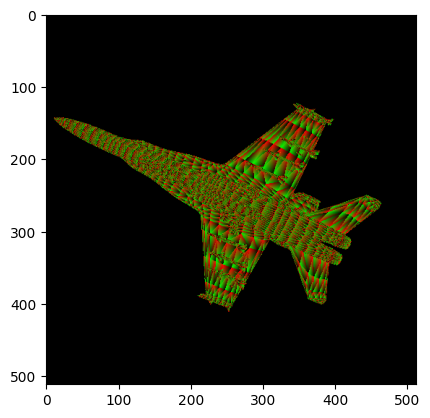

In [87]:
# Vertices in homogeneous coordinates
vertices_homogenous = torch.cat((vertices, torch.ones(vertices.shape[0], 1).to(device)), -1)
print("Vertices homogeneous:", vertices_homogenous.shape)

###############################################
# Create a camera
FOV = 60
DIST = 2.0

# -- Projection
fov = FOV*np.pi/180
aspect = 1
near = 0.1
far = 100
proj = np.array([ [1/(aspect*np.tan(fov/2)), 0, 0, 0],
                  [0, 1/np.tan(fov/2), 0, 0],
                  [0, 0, -(far+near)/(far-near), -2*far*near/(far-near)],
                  [0, 0, -1, 0] ])
proj = torch.tensor(proj, device=device, dtype=torch.float32)

# -- Camera
def camera_matrix(theta, phi):
    R = np.array([ [np.cos(theta), 0, np.sin(theta)],
                    [0, 1, 0],
                    [-np.sin(theta), 0, np.cos(theta)] ]) @ \
        np.array([ [1, 0, 0],
                    [0, np.cos(phi), -np.sin(phi)],
                    [0, np.sin(phi), np.cos(phi)] ])
    camera = np.eye(4)
    camera[:3, :3] = R
    # Add a translation
    camera = camera @ util.translate(0, 0, DIST)
    return camera
# Random rotation matrix
def random_camera_matrix():
    theta = np.random.rand() * 2 * np.pi
    phi = np.random.rand() * np.pi
    return camera_matrix(theta, phi)
    
camera = random_camera_matrix()
camera_inv = np.linalg.inv(camera)
camera = torch.tensor(camera, device=device, dtype=torch.float32)
camera_inv = torch.tensor(camera_inv, device=device, dtype=torch.float32)

################### Rasterize the mesh ###################
def transform_vertices(vertices_homogenous, model_matrix, camera_inv, proj):
    # Transform the vertices in world space
    vertices_homogenous = torch.matmul(model_matrix, vertices_homogenous.transpose(-1, -2)).transpose(-1, -2)
    # Transform the vertices inside the camera space
    vertices_cam = torch.matmul(camera_inv, vertices_homogenous.transpose(-1, -2)).transpose(-1, -2)
    # Project the vertices
    vertices_proj = torch.matmul(proj, vertices_cam.transpose(-1, -2)).transpose(-1, -2)
    # Normalize the vertices
    vertices_ndc = vertices_proj[:, :] / vertices_proj[:, 3:]
    return vertices_cam, vertices_ndc


# Rasterize the mesh
vertices_cam, vertices_ndc = transform_vertices(vertices_homogenous, model_matrix, camera_inv, proj)
vertices_ndc_final = vertices_ndc.unsqueeze(0).contiguous()
tri = faces.to(torch.int32).contiguous()
print("Vertices NDC:", vertices_ndc_final.shape)
print("Tri:", tri.shape)
rast, _ = dr.rasterize(glctx, vertices_ndc_final, tri, resolution=[512, 512])

# Show UV
rast_uv = rast[0, :, :, 0:2]
rast_uv = torch.cat((rast_uv, torch.zeros(rast_uv.shape[0], rast_uv.shape[1], 1).to(device)), -1)
view_uv = rast_uv.cpu().numpy().squeeze()
view_uv = view_uv[::-1, :, :] # flip vertically
plt.imshow(view_uv, cmap='gray')
plt.show()

Depth: tensor(0., device='cuda:0') tensor(0.9288, device='cuda:0')
Position 0.0 0.8546119
Depth 0.0 0.9288119
Mask 0.0 1.0


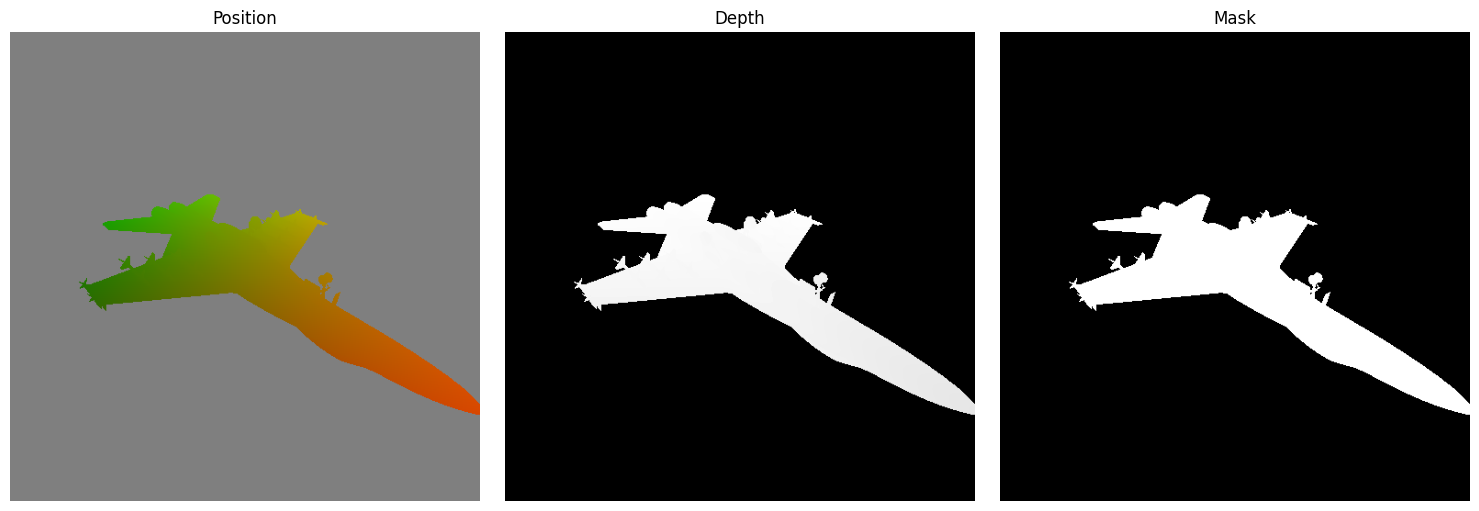

In [77]:
images = {}

# Compute camera space positions
postion_cam_interpolate, _ = dr.interpolate(vertices_cam[:, 0:3].contiguous(), rast, tri) # normals
images["Position"] = postion_cam_interpolate

# Compute depth
depth_interpolate, _ = dr.interpolate(vertices_ndc[:, 2].unsqueeze(-1).contiguous(), rast, tri) # depth
images["Depth"] = depth_interpolate
print("Depth:", depth_interpolate.min(), depth_interpolate.max())

# Mask
rast_mask = rast[0, :, :, 3] > 0 
images["Mask"] = rast_mask.float()

def prepare_image(image, normalize=True):
    image = image.cpu().numpy().squeeze()
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = image[::-1, :, :] # flip vertically
        if normalize:
            image = image *0.5 +0.5
    elif len(image.shape) == 2:
        image = image[::-1, :]
    image = np.clip(image, 0, 1)
    return image

fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
for (id, (name, image)) in enumerate(images.items()):
    image = prepare_image(image)
    print(name, image.min(), image.max())
    axs[id].imshow(image, cmap='gray')
    axs[id].set_title(name)
    axs[id].axis('off') 
plt.tight_layout()
plt.show()


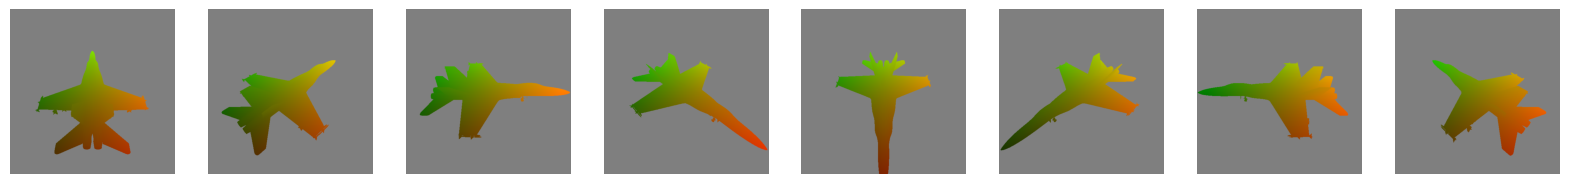

In [92]:
# Render 8 views
NB_VIEWS = 8
delta_theta = 2*np.pi/NB_VIEWS

fig, axs = plt.subplots(1, NB_VIEWS, figsize=(20, 5))
pos_camera = []
images_XYZ = []
images_mask = []
for id in range(NB_VIEWS):
    camera = camera_matrix(id*delta_theta, -np.pi/4)
    pos_camera.append(camera[:3, 3])
    camera_inv = np.linalg.inv(camera)
    camera_inv = torch.tensor(camera_inv, device=device, dtype=torch.float32)
    # Transform
    vertices_cam, vertices_ndc = transform_vertices(vertices_homogenous, model_matrix, camera_inv, proj)
    vertices_ndc_final = vertices_ndc.unsqueeze(0).contiguous()
    rast, _ = dr.rasterize(glctx, vertices_ndc_final, tri, resolution=[512, 512])
    
    # Compute camera space positions
    postion_cam_interpolate, _ = dr.interpolate(vertices_cam[:, 0:3].contiguous(), rast, tri) 
    postion_cam_interpolate = postion_cam_interpolate.squeeze()
    images_XYZ.append(postion_cam_interpolate)
    
    # Mask
    rast_mask = rast[0, :, :, 3] > 0
    images_mask.append(rast_mask.float())

    # Show camera space positions
    image = np.clip(postion_cam_interpolate.cpu().numpy() * 0.5 + 0.5, 0.0, 1.0)
    image = image[::-1, :, :] # flip vertically
    axs[id].imshow(image, cmap='gray')
    axs[id].axis('off')

In [74]:
# Prepare the images by stacking them
images_XYZ_stack = torch.stack(images_XYZ, 0)
images_mask_stack = torch.stack(images_mask, 0)
# Make batch size 1
images_XYZ_stack = images_XYZ_stack.unsqueeze(0)
images_mask_stack = images_mask_stack.unsqueeze(0)
# Check size
print(images_XYZ_stack.shape, images_mask_stack.shape)


torch.Size([1, 8, 512, 512, 3]) torch.Size([1, 8, 512, 512])


In [44]:
# Import the deep model
import sys
import os
sys.path.append(os.path.abspath('..'))

import PCGModel

In [ ]:
# Try trying the model with the same model
model = PCGModel.Structure_Generator(outViewN=8) # 128 x 128
